# Benchmarking the Fock approximation in bosonicplus vs the bosonic backend in strawberryfields

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import strawberryfields as sf
from strawberryfields.backends.states import BaseBosonicState

from bosonicplus.states.coherent import order_infidelity_fock_coherent, gen_fock_coherent
from bosonicplus.states.wigner import wig_mn, get_wigner_coherent
from bosonicplus.states.from_sf import prepare_fock_bosonic
from bosonicplus.quality.fidelity import fidelity_with_wigner
from bosonicplus.states.nongauss import prepare_fock_coherent
from bosonicplus.plotting import plot_wig

Superposition of coherent states for Fock 10
--------------------------------------------------
Magnitude of coherent states, eps = 1.5
Number of Gaussians = 121
Expected infidelity of approximation 5.314e-10
Numerical fidelity to analytical Fock 10, 1-F = 8.988e-10
Max coefficient = 8.6e+01

Linear combination of thermal states for Fock 10
--------------------------------------------------
Two mode squeezing in the approximation, r = 0.1
Number of Gaussians = 11
Numerical fidelity to analytical Fock 10, 1-F = 5.563e-01
Max coefficient = 2.7e+15


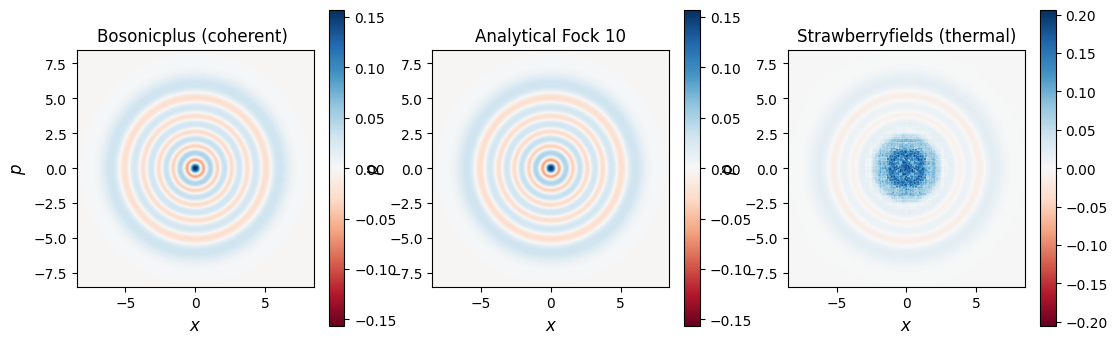

In [2]:
sf.hbar= 2
N = 10
epsilon = 1.5
x = np.sqrt(sf.hbar)*np.linspace(-6,6,300)


X, P = np.meshgrid(x,x )
W_fock = wig_mn(N,N, X, P)

print(f'Superposition of coherent states for Fock {N}')
print('-'*50)

data = gen_fock_coherent(N, 1, epsilon)
state = BaseBosonicState(data, 1, num_weights = len(data[2]))
infid = order_infidelity_fock_coherent(N, epsilon)
W = get_wigner_coherent(state, x, x)
covs, means, weights = data
fid = fidelity_with_wigner(W_fock, W, x, x).real

print(f'Magnitude of coherent states, eps = {epsilon}')
print(f'Number of Gaussians = {len(weights)}')
print('Expected infidelity of approximation {:.3e}'.format(infid))
print('Numerical fidelity to analytical Fock {}, 1-F = {:.3e}'.format(N, 1 - fid))
print('Max coefficient = {:.1e}'.format(np.abs(np.max(weights))))

print(f'\nLinear combination of thermal states for Fock {N}')
print('-'*50)

r = 0.1
th = prepare_fock_bosonic(N, r = r)
W_th = th.wigner(mode = 0, xvec = x, pvec = x)
fid_th = fidelity_with_wigner(W_fock, W_th, x, x).real

print(f'Two mode squeezing in the approximation, r = {r}')
print(f'Number of Gaussians = {len(th.data[2])}')
print('Numerical fidelity to analytical Fock {}, 1-F = {:.3e}'.format(N,1 - fid_th))
print('Max coefficient = {:.1e}'.format(np.abs(np.max(th.data[2]))))

fig, axes = plt.subplots(1,3, figsize = (13,5) )

plot_wig(axes[0], W, x, x)
axes[0].set_title(rf'Bosonicplus (coherent) ')


plot_wig(axes[1], W_fock ,x ,x )
axes[1].set_title(f'Analytical Fock {N}')

plot_wig(axes[2], W_th, x, x)
axes[2].set_title('Strawberryfields (thermal)')

plt.show()

## Fidelity of the Fock approximations
Here the fidelity of the Fock approximation from `strawberryfield`'s bosonic backend (using linear combinations of thermal states) and `bosonicplus` (using superpositions of coherent states) is compared. The fidelity is computed by performing the overlap integral $\int d^2{\xi} W_{\ket{n}\bra{n}}(\xi)\tilde{W}_{\ket{n}\bra{n}}(\xi)$ numerically. 

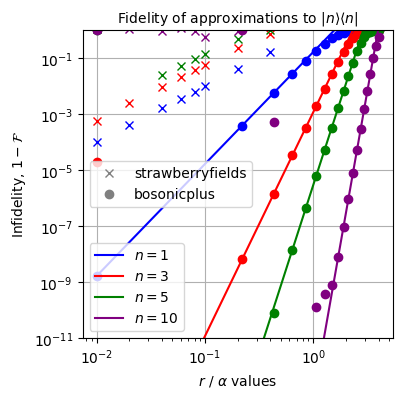

In [3]:
fig, axes = plt.subplots(1, figsize = (4,4))
sf.hbar = 1

N = np.array([1, 3, 5, 10])

colors = ['b','r','g','purple','c','k']

epsilons = np.linspace(1e-2,4, 20)
#epsilons = np.array([1e-1,2e-1])

x = np.sqrt(sf.hbar)*np.linspace(-6,6,300)

for i, n in enumerate(N):

    infidelities = order_infidelity_fock_coherent(n, epsilons)

    #numerical infidelity
    X,P = np.meshgrid(x,x) #Has to be inside the loop for some reason, otherwise the x scaling of W_fock changes
    W_fock = wig_mn(n,n,X,P)
    
    fidelities = np.zeros(len(epsilons))
    for j, eps in enumerate(epsilons):
        
        data = gen_fock_coherent(n, 1, eps)
        state = BaseBosonicState(data, 1, num_weights = len(data[2]))
        W_coherent = get_wigner_coherent(state, x, x)
        
        fid = fidelity_with_wigner(W_fock, W_coherent, x, x).real
        #if np.abs(1-fid - infidelities[j]) < infidelities[j]:
        
        axes.loglog(eps, 1-fid, 'o', color = colors[i] )
    axes.loglog(epsilons, infidelities, color = colors[i], label = rf'$n={n}$')
    
    rs = np.array([1e-2, 2e-2, 4e-2, 6e-2,8e-2,1e-1, 2e-1, 4e-1]) 
    
    for j, r in enumerate(rs):
        if 1/r**2 > n:
            th = prepare_fock_bosonic(n, r = r)
            W_th = th.wigner(mode = 0, xvec = x, pvec = x)
            fid = fidelity_with_wigner(W_fock, W_th, x, x).real
            #fidelities[j] = fid.real
            if j != len(rs) -1:
                axes.loglog(r, 1-fid, 'x', color = colors[i])
            else:
                axes.loglog(r, 1-fid, 'x', color = colors[i])
            
th = matplotlib.lines.Line2D([], [], color='gray', marker='x', linestyle='None',label ='strawberryfields')
coh = matplotlib.lines.Line2D([], [], color='gray', marker='o', linestyle='None',label ='bosonicplus')

axes.set_xlabel(r'$r$ / $\alpha$ values')
#axes.set_ylabel(r'$\mathcal{O}(1-\mathcal{F}(\left|N\right>,\left|\tilde{N}\right>))$')
axes.set_ylabel(r'Infidelity, $1-\mathcal{F}$')
axes.set_ylim([1e-11,1e-0])
#axes.set_xlim([1e-2,4e-1])
l1 = axes.legend(handles = [th, coh], loc = "center left")
axes.legend(loc = "lower left")
axes.add_artist(l1)
axes.grid('on')
axes.set_title(r'Fidelity of approximations to $|n\rangle \langle n|$', fontsize =10)
#plt.show()


#plt.savefig('Fock_approx_coherent.png')
#plt.tight_layout()
#plt.savefig('fock-approx-figs/fock-approx.pdf', bbox_inches = 'tight',transparent = True, pad_inches = 0)
plt.show()

## psuedo PNRD as an approximation to PNRD
The PNRD POVM $\hat{\Pi}_n=\ket{n}\bra{n}$, which is approximated by a linear combination of Gaussians (thermal states) in strawberryfields, can also be approximated by the pseudo PNRD POVM $\hat{\Pi}_k=\dots$, which is also a linear combination of Gaussians. Interestingly, the pPNRD approximation is nearly equivalent to the bosonic backend approximation for PNRD (with default value `r=0.05`) when the number of on/off detectors is `M=399`. 

In [46]:
from bosonicplus.states.from_sf import prepare_fock_bosonic
from bosonicplus.measurements.photon_counting import ppnrd_povm_thermal

In [74]:
#Compare PPNRD data with fock from bosonic backend data
n = 4
ppnrd_data = ppnrd_povm_thermal(n, 399)
fock_data = prepare_fock_bosonic(n).data

print(f'Covs from fock: \n{fock_data[1]}')
print(f'\nCovs from ppnrd: \n{ppnrd_data[1]}')

print(f'Weights from fock: {fock_data[2]}')
print(f'\nWeights from ppnrd: {ppnrd_data[2]}')

Covs from fock: 
[[[1.02020202 0.        ]
  [0.         1.02020202]]

 [[1.01511335 0.        ]
  [0.         1.01511335]]

 [[1.01005025 0.        ]
  [0.         1.01005025]]

 [[1.00501253 0.        ]
  [0.         1.00501253]]

 [[1.         0.        ]
  [0.         1.        ]]]

Covs from ppnrd: 
[[[1.02025316 0.        ]
  [0.         1.02025316]]

 [[1.01515152 0.        ]
  [0.         1.01515152]]

 [[1.01007557 0.        ]
  [0.         1.01007557]]

 [[1.00502513 0.        ]
  [0.         1.00502513]]

 [[1.         0.        ]
  [0.         1.        ]]]
Weights from fock: [ 1.05073971e+09+0.j -4.19237203e+09+0.j  6.27275765e+09+0.j
 -4.17135764e+09+0.j  1.04023231e+09+0.j]

Weights from ppnrd: [ 1.0507665e+09 -4.1924522e+09  6.2728378e+09 -4.1713846e+09
  1.0402325e+09]
